In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F
import PIL.Image as Image

In [2]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [3]:
class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
           # input is Z, going into a convolution
            nn.ConvTranspose2d(20, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # nn.BatchNorm2d(64),
            # nn.ReLU(True),
            # # state size. (64) x 32 x 32
            # nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            # nn.Tanh()
            # state size. (3) x 64 x 64
        )
        
     
        
    def forward(self, x):
        
        x = self.generator(x)
        
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(4, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2,inplace=True),

            # nn.Conv2d(128, 64, 3, 2, 1, bias=False),
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),

        )
          
        # self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.discriminator(x) # [100, 64, 2, 2])

        # x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1) # [100, 64]
       
        # output = self.fc(x)
        # print(output.shape)
        return x

In [4]:
flag_gpu = 1
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 10
# Learning rate for optimizers
lr = 0.0004

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 10
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

GPU State: cuda:0


In [5]:
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

       
        #  ---------Train Generator-------------------------
        
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1) # G input
        label_one_hot = torch.reshape(F.one_hot(label,10),(images.shape[0], latent_dim, 1, 1))
        noise = torch.cat((noise,label_one_hot),1)

        # print(label_one_hot.shape) 
        # print(noise.shape,label)
        noise = noise.to(device)
        
        # fake_label 
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1

        # Generate a batch of images
        fake_inputs = G(noise)
        # print(label)
        print(fake_inputs.shape)
        D_label = label[0]*torch.ones(1,1,32,32)
        # print(D_label)
        for i in range(1,images.shape[0]):
            tmp = label[i]*torch.ones(1,1,32,32)
            D_label = torch.cat((D_label,tmp),0)
            # print(D_label.shape)
        D_label = D_label.to(device)
        print(fake_inputs.shape)
        fake_inputs = torch.cat((fake_inputs,D_label),1)
        # print(fake_inputs.shape)
        fake_outputs = D(fake_inputs)
        print(fake_outputs.shape)
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        

        
        # -------------Train Discriminator----------------
        # Zero the parameter gradients
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用 0
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
        # print(real_inputs.shape,real_label.shape,fake_label.shape)
        D_label = label[0]*torch.ones(1,1,32,32)
        for i in range(1,images.shape[0]):
            tmp = label[i]*torch.ones(1,1,32,32)
            D_label = torch.cat((D_label,tmp),0)
            # print(tmp)
        # print(D_label.shape)
        # print(real_inputs.shape)
        D_label = D_label.to(device)
        real_inputs = torch.cat((real_inputs,D_label),1)
        # print(real_inputs.shape)
        # print(real_label.shape)
#       learning by Discriminator
        # print('test',real_inputs.shape)
        real_loss = adversarial_loss(D(real_inputs),real_label)
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label)

        loss_d_value = (real_loss + fake_loss) / 2
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    g_scheduler.step()
    d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    print('Cost Time: {}s'.format(time.time()-start_time))
    
        
#         plt.show()

# torch.save(G, 'DCGAN_Generator.pth')
# torch.save(D, 'DCGAN_Discriminator.pth')
# print('Model saved.')

print('Training Finished.')


torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [100]

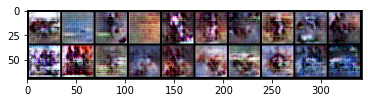

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

G.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(model):

    with torch.no_grad():
    
        noise = torch.randn(20, latent_dim, 1, 1)
        noise = noise.to(device)
        
        label = torch.tensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9])
        
        label_one_hot = torch.reshape(F.one_hot(label,10),(20, latent_dim, 1, 1))
        label_one_hot = label_one_hot.to(device)
        noise = torch.cat((noise,label_one_hot),1)

        images = G(noise)
        images = images.cpu()
        images = to_img(images)
        
        np_imagegrid = torchvision.utils.make_grid(images[0:20], 10, 2).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

# plt.show()
visualise_output(G)

